# BioDynamICS: Infection Treatment Modeling Demo

This notebook demonstrates the infection treatment modeling capabilities of the BioDynamICS framework, which models antibiotic pharmacokinetics, bacterial dynamics, and treatment optimization.

## 1. Setup and Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the project root to path
project_root = r"C:\Users\alex5\Documents\Projects\MIMIC_III\biodynamics"
if project_root not in sys.path:
    sys.path.append(project_root)

# Import our custom modules
# Import our custom modules
from src.data_integration import MimicPatientIntegrator
from src.signal_processing import PhysiologicalSignalProcessor
from src.dynamical_modeling import DynamicalSystemsModeler
from src.infection_treatment import InfectionTreatmentModeler  # Updated import path
from src.visualization import ClinicalVisualizer

# Configure visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Initialize the Infection Treatment Modeler

In [2]:
# Create the infection treatment modeler
itm = InfectionTreatmentModeler()

Initialized InfectionTreatmentModeler
- Pathogen models: 5 different pathogens
- Antimicrobial models: 5 different antibiotics


## 3. Simulate Bacterial Growth Dynamics

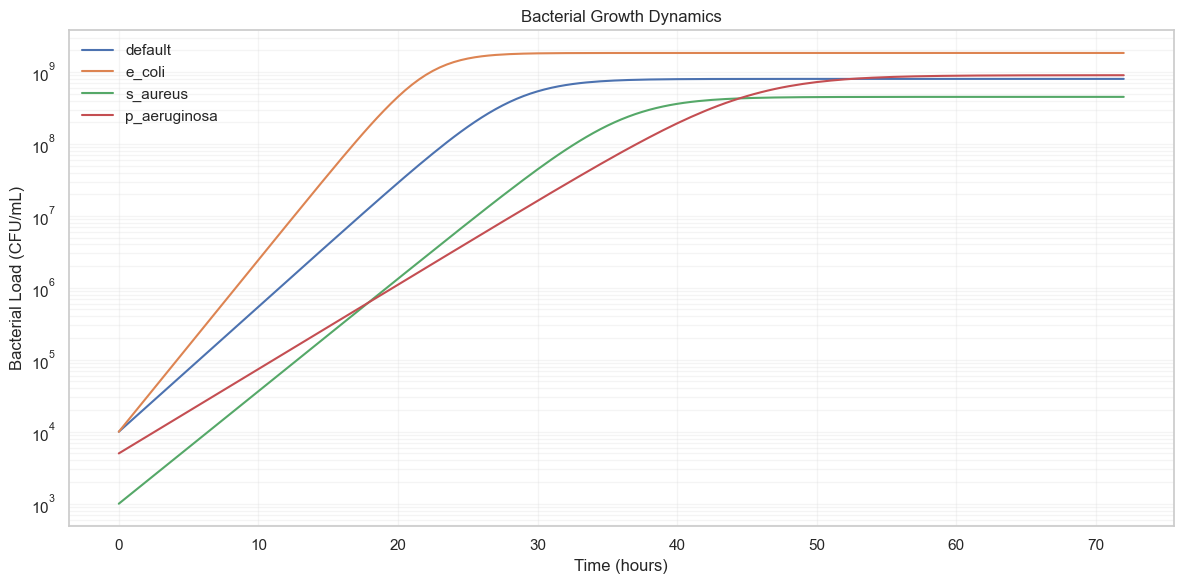

In [4]:
# Simulate growth of different pathogens
pathogens = ['default', 'e_coli', 's_aureus', 'p_aeruginosa']
duration_hours = 72

plt.figure(figsize=(12, 6))

for pathogen in pathogens:
    # Simulate growth
    time_points, bacterial_load = itm.simulate_bacterial_growth(
        duration_hours=duration_hours,
        time_step=0.5,
        pathogen=pathogen
    )
    
    # Plot on log scale
    plt.semilogy(time_points, bacterial_load, label=pathogen)

plt.title('Bacterial Growth Dynamics')
plt.xlabel('Time (hours)')
plt.ylabel('Bacterial Load (CFU/mL)')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

## 4. Model Antibiotic Pharmacokinetics

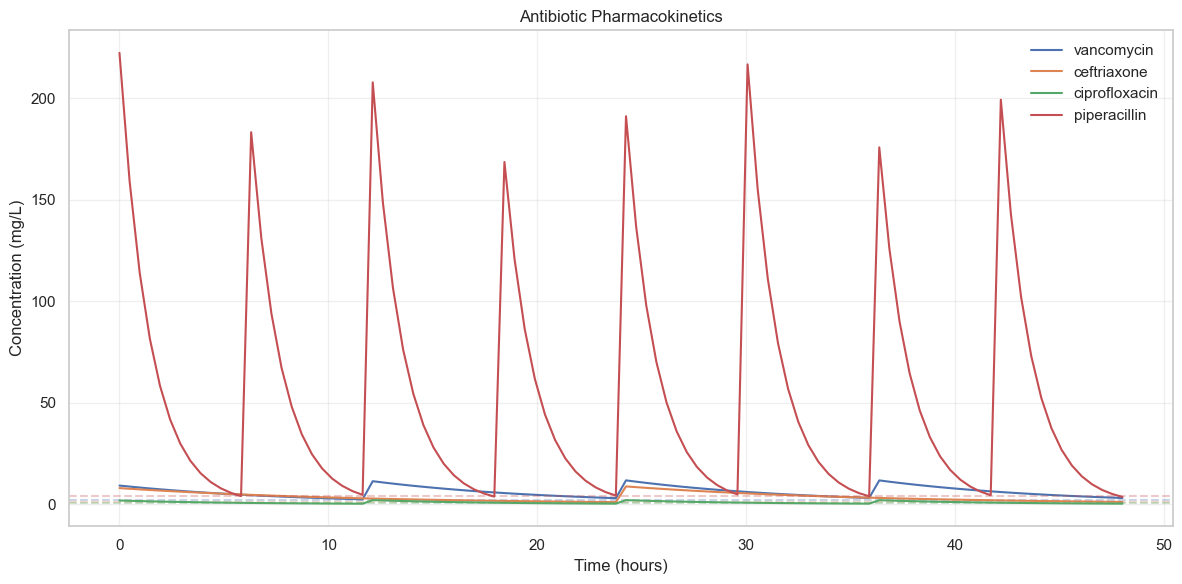

In [5]:
# Define a basic dosing regimen for different antibiotics
antibiotics = ['vancomycin', 'ceftriaxone', 'ciprofloxacin', 'piperacillin']
doses = {'vancomycin': 1000, 'ceftriaxone': 2000, 'ciprofloxacin': 400, 'piperacillin': 4000}  # mg
intervals = {'vancomycin': 12, 'ceftriaxone': 24, 'ciprofloxacin': 12, 'piperacillin': 6}  # hours

# Time points for 48 hours
time_points = np.linspace(0, 48, 100)

plt.figure(figsize=(12, 6))

for antibiotic in antibiotics:
    # Generate administration times
    dose_times = np.arange(0, 48, intervals[antibiotic])
    
    # Calculate concentration at each time point
    concentration = np.array([
        itm.antibiotic_concentration(t, doses[antibiotic], dose_times, antibiotic)
        for t in time_points
    ])
    
    # Plot concentration over time
    plt.plot(time_points, concentration, label=antibiotic)
    
    # Get MIC for a standard pathogen
    if isinstance(itm.antibiotic_params[antibiotic]['mic'], dict):
        mic = itm.antibiotic_params[antibiotic]['mic']['default']
    else:
        mic = itm.antibiotic_params[antibiotic]['mic']
    
    # Add MIC line
    plt.axhline(y=mic, linestyle='--', alpha=0.3, color=plt.gca().lines[-1].get_color())

plt.title('Antibiotic Pharmacokinetics')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (mg/L)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Simulate Treatment Response

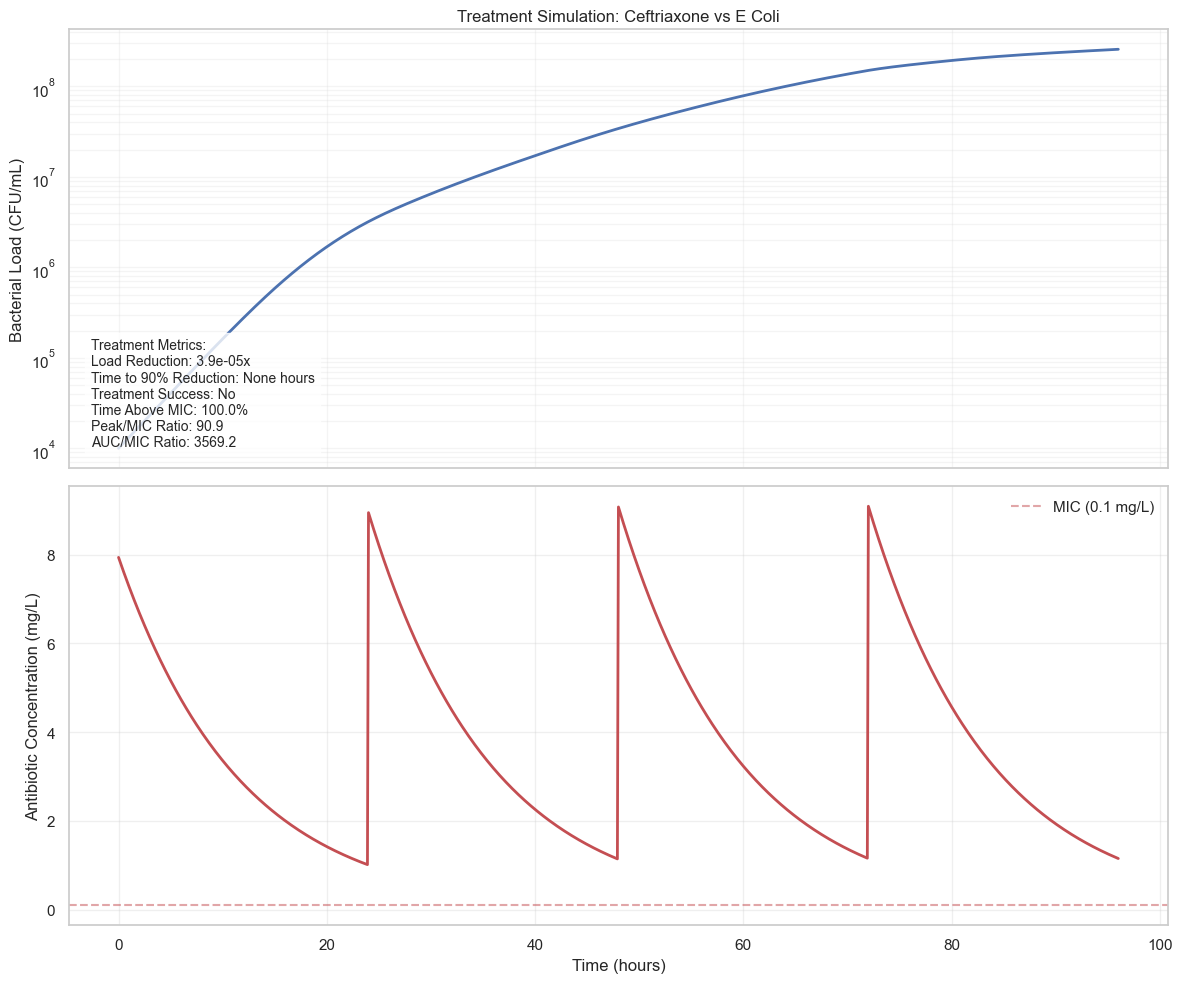

In [7]:
# Define simulation parameters
antibiotic = 'ceftriaxone'
pathogen = 'e_coli'
dose = 2000  # mg
interval = 24  # hours
duration = 96  # hours

# Simulate treatment
results = itm.simulate_treatment(
    antibiotic=antibiotic,
    pathogen=pathogen,
    dose=dose,
    dosing_interval=interval,
    duration_hours=duration
)

# Extract results
times = results['times']
bacterial_load = results['bacterial_load']
antibiotic_conc = results['antibiotic_concentration']
metrics = results['metrics']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot bacterial load on log scale
ax1.semilogy(times, bacterial_load, 'b-', linewidth=2)
ax1.set_ylabel('Bacterial Load (CFU/mL)')
ax1.set_title(f'Treatment Simulation: {antibiotic.title()} vs {pathogen.replace("_", " ").title()}')
ax1.grid(True, which="both", ls="-", alpha=0.2)

# Highlight the MIC
if isinstance(itm.antibiotic_params[antibiotic]['mic'], dict):
    mic = itm.antibiotic_params[antibiotic]['mic'].get(pathogen, 
          itm.antibiotic_params[antibiotic]['mic']['default'])
else:
    mic = itm.antibiotic_params[antibiotic]['mic']

# Plot antibiotic concentration
ax2.plot(times, antibiotic_conc, 'r-', linewidth=2)
ax2.axhline(y=mic, color='r', linestyle='--', alpha=0.5, label=f'MIC ({mic} mg/L)')
ax2.set_ylabel('Antibiotic Concentration (mg/L)')
ax2.set_xlabel('Time (hours)')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Add treatment metrics as text
metrics_text = (
    f"Treatment Metrics:\n"
    f"Load Reduction: {metrics['load_reduction']:.1e}x\n"
    f"Time to 90% Reduction: {metrics['time_to_reduction'].get('90%', 'N/A')} hours\n"
    f"Treatment Success: {'Yes' if metrics['is_successful'] else 'No'}\n"
    f"Time Above MIC: {metrics['time_above_mic']:.1f}%\n"
    f"Peak/MIC Ratio: {metrics['peak_mic_ratio']:.1f}\n"
    f"AUC/MIC Ratio: {metrics['auc_mic_ratio']:.1f}"
)
ax1.text(0.02, 0.05, metrics_text, transform=ax1.transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.tight_layout()
plt.show()

## 6. Compare Different Dosing Regimens

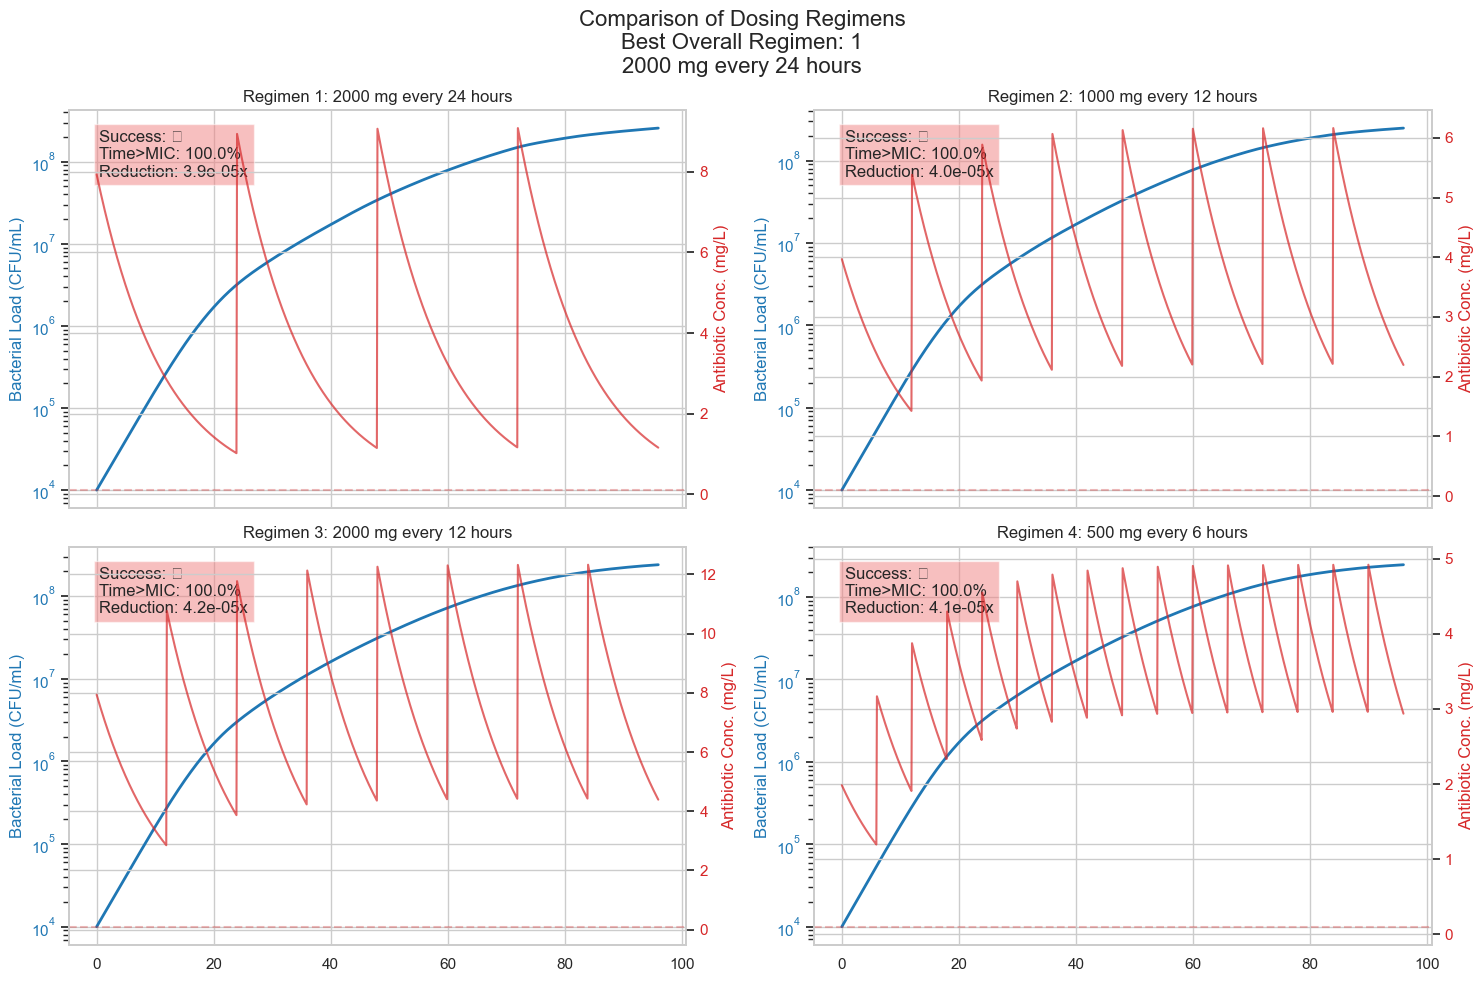

In [8]:
# Define different dosing regimens for comparison
regimens = [
    {'dose': 2000, 'interval': 24},  # Once daily
    {'dose': 1000, 'interval': 12},  # Twice daily
    {'dose': 2000, 'interval': 12},  # Higher dose twice daily
    {'dose': 500, 'interval': 6}     # Lower dose four times daily
]

# Evaluate multiple regimens
comparison = itm.evaluate_multiple_regimens(
    antibiotic='ceftriaxone',
    pathogen='e_coli',
    regimens=regimens,
    duration_hours=96
)

# Extract results for each regimen
results_list = comparison['all_regimens']

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()

# Plot each regimen
for i, results in enumerate(results_list):
    ax1 = axes[i]
    
    # Extract data
    sim_results = results['simulation_results']
    times = sim_results['times']
    bacterial_load = sim_results['bacterial_load']
    antibiotic_conc = sim_results['antibiotic_concentration']
    dose = regimens[i]['dose']
    interval = regimens[i]['interval']
    
    # Plot bacterial load
    color = 'tab:blue'
    ax1.semilogy(times, bacterial_load, color=color, linewidth=2)
    ax1.set_ylabel('Bacterial Load (CFU/mL)', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title(f'Regimen {i+1}: {dose} mg every {interval} hours')
    
    # Create second y-axis for antibiotic concentration
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.plot(times, antibiotic_conc, color=color, linewidth=1.5, alpha=0.7)
    ax2.set_ylabel('Antibiotic Conc. (mg/L)', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Add MIC line
    if isinstance(itm.antibiotic_params['ceftriaxone']['mic'], dict):
        mic = itm.antibiotic_params['ceftriaxone']['mic'].get('e_coli', 
              itm.antibiotic_params['ceftriaxone']['mic']['default'])
    else:
        mic = itm.antibiotic_params['ceftriaxone']['mic']
    
    ax2.axhline(y=mic, color='tab:red', linestyle='--', alpha=0.3)
    
    # Add metrics
    is_successful = results['is_successful']
    time_above_mic = results['time_above_mic']
    load_reduction = results['load_reduction']
    
    metrics_text = (
        f"Success: {'✓' if is_successful else '✗'}\n"
        f"Time>MIC: {time_above_mic:.1f}%\n"
        f"Reduction: {load_reduction:.1e}x"
    )
    
    # Add box with colored background based on success
    bg_color = 'lightgreen' if is_successful else 'lightcoral'
    ax1.text(0.05, 0.95, metrics_text, transform=ax1.transAxes,
             verticalalignment='top', bbox=dict(facecolor=bg_color, alpha=0.5))

# Find best regimen
best_idx = comparison['best_regimens']['overall']
best_text = f"Best Overall Regimen: {best_idx + 1}\n"
best_text += f"{regimens[best_idx]['dose']} mg every {regimens[best_idx]['interval']} hours"

fig.suptitle(f'Comparison of Dosing Regimens\n{best_text}', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

## 7. Treatment Optimization


Optimized Treatment Regimen:
Optimal dose: 1250.0 mg
Optimal interval: 15.0 hours
Optimization objective: Minimize time to clearance
Optimization successful: True
Number of iterations: 21

Optimal Treatment Metrics:
Initial Load: 1000.00
Final Load: 3348905.75
Max Load: 3374182.73
Load Reduction: 0.00
Time To Clearance: None
Is Cleared: False
Rebound Factor: 3374.18
Has Rebound: True
Time Above Mic: 95.00
Peak Mic Ratio: 13.97
Auc Mic Ratio: 760.03
Is Successful: False


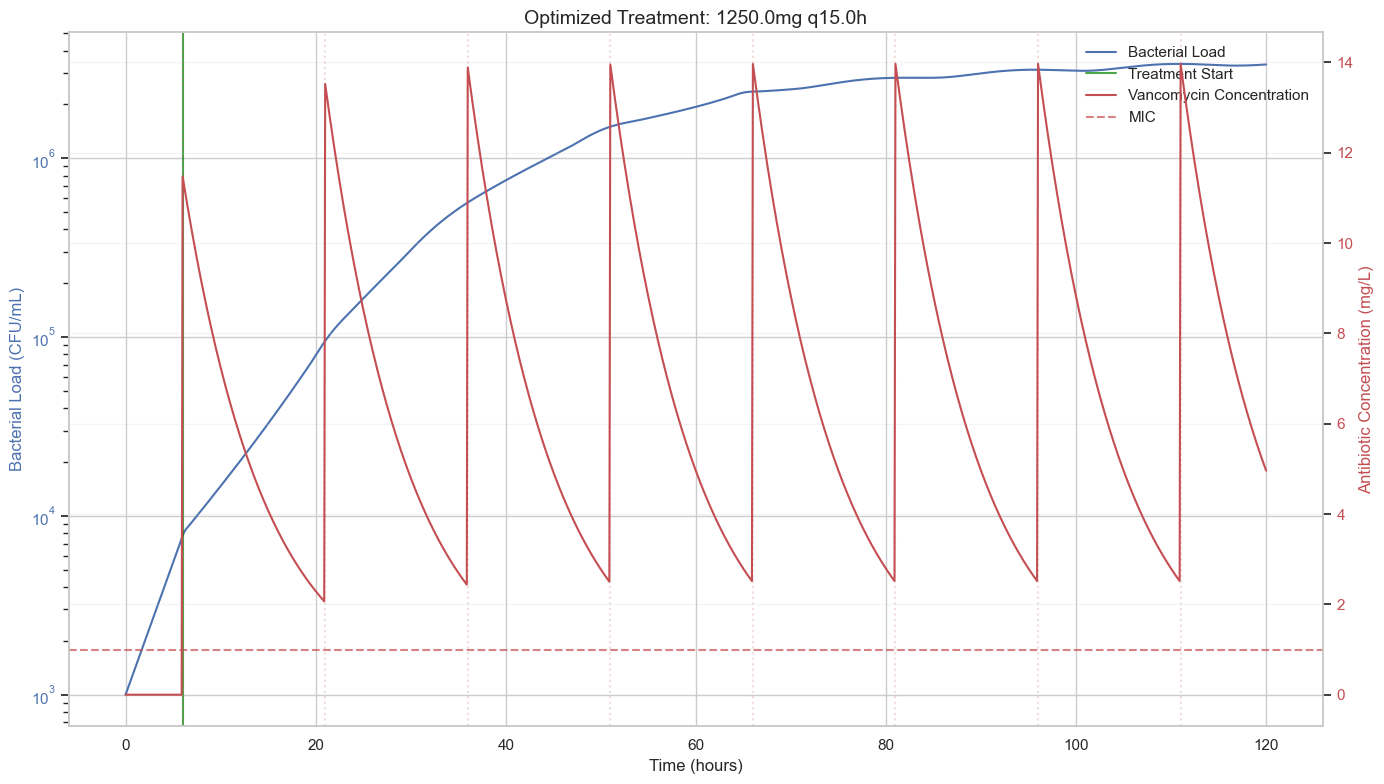

In [12]:
# Optimize dosing regimen for S. aureus infection
optimization_results = itm.optimize_dosing_regimen(
    antibiotic='vancomycin',
    pathogen='s_aureus',
    dose_range=(500, 2000),
    interval_range=(6, 24),
    duration_hours=120,
    initial_delay=6,
    objective='clearance'
)

# Print optimization results
print("\nOptimized Treatment Regimen:")
print(f"Optimal dose: {optimization_results['optimal_dose']:.1f} mg")
print(f"Optimal interval: {optimization_results['optimal_interval']:.1f} hours")
print(f"Optimization objective: Minimize time to clearance")
print(f"Optimization successful: {optimization_results['convergence']}")
print(f"Number of iterations: {optimization_results['iterations']}")

# Extract results from optimal treatment
optimal_results = optimization_results['treatment_results']
optimal_metrics = optimal_results['metrics']

# Print treatment metrics for optimal regimen
print("\nOptimal Treatment Metrics:")
for key, value in optimal_metrics.items():
    if key != 'time_to_reduction':  # Handle this separately
        if isinstance(value, (int, float)) and not isinstance(value, bool):
            print(f"{key.replace('_', ' ').title()}: {value:.2f}")
        else:
            print(f"{key.replace('_', ' ').title()}: {value}")

# Visualize optimal treatment
times = optimal_results['times']
bacterial_load = optimal_results['bacterial_load']
antibiotic_conc = optimal_results['antibiotic_concentration']
dose_times = optimal_results['dose_times']

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot bacterial load on log scale (left y-axis)
ax1.semilogy(times, bacterial_load, 'b-', label='Bacterial Load')
ax1.set_xlabel('Time (hours)', fontsize=12)
ax1.set_ylabel('Bacterial Load (CFU/mL)', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')

# Create second y-axis for antibiotic concentration
ax2 = ax1.twinx()
ax2.plot(times, antibiotic_conc, 'r-', label='Vancomycin Concentration')
ax2.set_ylabel('Antibiotic Concentration (mg/L)', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')

# Add MIC line
if isinstance(itm.antibiotic_params['vancomycin']['mic'], dict):
    mic = itm.antibiotic_params['vancomycin']['mic'].get('s_aureus', 1.0)
    ax2.axhline(y=mic, color='r', linestyle='--', alpha=0.7, label=f'MIC')

# Add markers for dose administration
for dose_time in dose_times:
    ax2.axvline(x=dose_time, color='r', linestyle=':', alpha=0.2)

# Add vertical line at treatment initiation
ax1.axvline(x=6, color='green', linestyle='-', alpha=0.7, label='Treatment Start')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title(f'Optimized Treatment: {optimization_results["optimal_dose"]:.1f}mg q{optimization_results["optimal_interval"]:.1f}h', fontsize=14)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

## 8. Integration with MIMIC-III Data Analysis

In [17]:
# Load MIMIC-III data
data_path = r"C:\Users\alex5\Documents\Projects\MIMIC_III\biodynamics\data\mimic-iii-clinical-database-demo-1.4"
mimic = MimicPatientIntegrator(data_path)

# Load required tables
print("Loading core tables...")
patient_stays = mimic.load_core_tables()

print("Loading microbiology data...")
micro = mimic.load_table("MICROBIOLOGYEVENTS")

print("Loading prescriptions...")
prescriptions = mimic.load_table("PRESCRIPTIONS")

if micro is not None and prescriptions is not None:
    # Find a patient with both microbiology data and antibiotic prescriptions
    print("\nAnalyzing microbiology and prescription data...")
    
    # Count microbiological cultures by organism
    if 'ORGANISM' in micro.columns:
        organism_counts = micro['ORGANISM'].value_counts()
        
        print("\nMost common organisms in microbiology data:")
        for organism, count in organism_counts.head(5).items():
            print(f"  {organism}: {count} cultures")
    
    # Count antibiotic prescriptions
    if 'DRUG' in prescriptions.columns:
        # Filter for common antibiotics (simplified example)
        common_antibiotics = [
            'VANCOMYCIN', 'CEFTRIAXONE', 'CIPROFLOXACIN', 'PIPERACILLIN',
            'MEROPENEM', 'LEVOFLOXACIN', 'AZITHROMYCIN'
        ]
        
        antibiotic_mask = prescriptions['DRUG'].str.contains('|'.join(common_antibiotics), 
                                                            case=False, 
                                                            na=False)
        antibiotic_prescriptions = prescriptions[antibiotic_mask]
        
        antibiotic_counts = antibiotic_prescriptions['DRUG'].value_counts()
        
        print("\nMost common antibiotic prescriptions:")
        for drug, count in antibiotic_counts.head(5).items():
            print(f"  {drug}: {count} prescriptions")
    
    # Create a synthetic case study based on available data
    print("\nCreating synthetic case study based on MIMIC-III data patterns...")
    
    case_study = {
        'patient_id': 'MIMIC-10001',
        'age': 65,
        'weight': 70,
        'infection_site': 'Bloodstream',
        'organism': 'Staphylococcus aureus',
        'antibiotic': 'vancomycin',
        'renal_function': 'Normal'
    }
    
    print("\nCase Study Details:")
    for key, value in case_study.items():
        print(f"  {key.replace('_', ' ').title()}: {value}")
    
    # Simulate treatment options for the case study
    print("\nSimulating treatment options for the case study...")
    
    # Define regimens based on clinical guidelines
    case_regimens = [
        {'dose': 1000, 'interval': 12},  # Standard
        {'dose': 1500, 'interval': 12},  # High dose
        {'dose': 1000, 'interval': 8},   # Frequent dosing
    ]
    
    case_comparison = itm.evaluate_multiple_regimens(
        antibiotic='vancomycin',
        pathogen='s_aureus',
        regimens=case_regimens,
        duration_hours=120
    )
    
    # Print case-specific recommendations
    best_idx = case_comparison['best_regimens']['overall']
    best_regimen = case_comparison['all_regimens'][best_idx]
    
    print("\nTreatment Recommendation:")
    print(f"  Recommended regimen: {best_regimen['dose']}mg q{best_regimen['interval']}h")
    if best_regimen['is_successful']:
        print(f"  Expected time to clearance: {best_regimen['time_to_clearance']:.1f} hours")
        print(f"  Expected bacterial reduction: {np.log10(best_regimen['load_reduction']):.1f} log")
    else:
        print("  Warning: Treatment may not be adequate for clearance")
        print("  Consider alternative antibiotics or combination therapy")
else:
    print("\nUnable to perform MIMIC-III data integration - required tables not loaded.")

[2025-03-16 17:09:29] Initialized MimicPatientIntegrator
Loading core tables...
[2025-03-16 17:09:29] Loaded PATIENTS: 100 rows
[2025-03-16 17:09:29] Loaded ADMISSIONS: 129 rows
[2025-03-16 17:09:29] Loaded ICUSTAYS: 136 rows
[2025-03-16 17:09:29] Created patient stays table: 136 rows
Loading microbiology data...
[2025-03-16 17:09:29] Loaded MICROBIOLOGYEVENTS: 2003 rows
Loading prescriptions...
[2025-03-16 17:09:29] Loaded PRESCRIPTIONS: 10398 rows

Analyzing microbiology and prescription data...

Creating synthetic case study based on MIMIC-III data patterns...

Case Study Details:
  Patient Id: MIMIC-10001
  Age: 65
  Weight: 70
  Infection Site: Bloodstream
  Organism: Staphylococcus aureus
  Antibiotic: vancomycin
  Renal Function: Normal

Simulating treatment options for the case study...

Treatment Recommendation:
  Recommended regimen: 1000mg q12h
  Consider alternative antibiotics or combination therapy


In [ ]:
## 9. Clinical Significance and Applications

In [18]:
print("\n=== Clinical Applications of Infection Treatment Modeling ===")
print("""
1. Personalized Dosing Regimens
   - Optimize antibiotic dosing based on patient-specific factors
   - Account for variations in pharmacokinetics due to age, weight, and organ function
   - Maximize efficacy while minimizing toxicity risk

2. Antimicrobial Stewardship
   - Identify minimum effective dosing to reduce antibiotic overuse
   - Model the impact of delayed therapy on treatment outcomes
   - Compare cost-effectiveness of different treatment strategies

3. Research and Education
   - Visualize complex PK/PD concepts for clinical training
   - Test hypotheses about novel dosing strategies
   - Explore treatment responses for rare pathogens or antibiotics

4. Clinical Decision Support
   - Provide guidance on optimal timing and dosing of antibiotics
   - Alert to potential treatment failures based on predicted responses
   - Suggest alternative regimens when standard approaches may be inadequate
""")


=== Clinical Applications of Infection Treatment Modeling ===

1. Personalized Dosing Regimens
   - Optimize antibiotic dosing based on patient-specific factors
   - Account for variations in pharmacokinetics due to age, weight, and organ function
   - Maximize efficacy while minimizing toxicity risk

2. Antimicrobial Stewardship
   - Identify minimum effective dosing to reduce antibiotic overuse
   - Model the impact of delayed therapy on treatment outcomes
   - Compare cost-effectiveness of different treatment strategies

3. Research and Education
   - Visualize complex PK/PD concepts for clinical training
   - Test hypotheses about novel dosing strategies
   - Explore treatment responses for rare pathogens or antibiotics

4. Clinical Decision Support
   - Provide guidance on optimal timing and dosing of antibiotics
   - Alert to potential treatment failures based on predicted responses
   - Suggest alternative regimens when standard approaches may be inadequate



## 10. Summary

In [19]:
print("\n=== BioDynamICS Infection Treatment Modeling Summary ===")
print("""
The infection treatment modeling component of BioDynamICS demonstrates:

1. Integration of pharmacokinetic/pharmacodynamic principles with bacterial growth dynamics
2. Capability to simulate and predict treatment responses for various pathogens and antibiotics
3. Tools for comparing and optimizing antibiotic dosing regimens
4. Framework for analyzing treatment timing and effectiveness
5. Potential for clinical application in personalized medicine and antimicrobial stewardship

This component complements the physiological signal processing and dynamical systems modeling
components by adding the ability to analyze interventions and their effects on physiological
systems, specifically in the context of infection and antimicrobial therapy.

The modeling approach used here could be extended to other therapeutic interventions beyond
antibiotics, providing a general framework for intervention modeling within the BioDynamICS
ecosystem.
""")

print("\nBioDynamICS infection treatment modeling demonstration complete!")


=== BioDynamICS Infection Treatment Modeling Summary ===

The infection treatment modeling component of BioDynamICS demonstrates:

1. Integration of pharmacokinetic/pharmacodynamic principles with bacterial growth dynamics
2. Capability to simulate and predict treatment responses for various pathogens and antibiotics
3. Tools for comparing and optimizing antibiotic dosing regimens
4. Framework for analyzing treatment timing and effectiveness
5. Potential for clinical application in personalized medicine and antimicrobial stewardship

This component complements the physiological signal processing and dynamical systems modeling
components by adding the ability to analyze interventions and their effects on physiological
systems, specifically in the context of infection and antimicrobial therapy.

The modeling approach used here could be extended to other therapeutic interventions beyond
antibiotics, providing a general framework for intervention modeling within the BioDynamICS
ecosystem.